# Machine Learning (XAI501)
# Assignment 3.2
# Taejin Woo (2021021576)

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Get dataset

In [2]:
with open("./gmm_data.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        line = line.strip()
        lines[i] = list(map(float, line.strip().split()))
raw_data = np.asarray(lines)

## Class : Gaussian mixture model

In [3]:
class GaussianMixtureModel(object):
    def __init__(self, k=2):
        self.data = np.nan
        self.means = np.nan
        self.covs = np.nan
        self.priors = np.nan
        self.responsibility = np.nan
        self.k = k
        self.learned = False
        self.likelihood = 0


    def initialize(self, k):
        self.data = np.nan
        self.means = np.nan
        self.covs = np.nan
        self.priors = np.nan
        self.k = k
        self.responsibility = np.nan
        self.learned = False
        self.likelihood = 0


    def calculate(self, data):
        self.data = data
        n_data = np.shape(data)[0]
        n_variable = np.shape(data)[1]

        # Initialize means, covs, priors
        init_idx = np.random.choice(range(n_data), self.k, replace=False)

        self.means = data[init_idx, :]
        self.covs = [np.identity(n_variable) for _ in range(self.k)]
        self.priors = [1.0 / self.k for _ in range(self.k)]

        # for iteration until it converges
        while True:
            new_likelihood = 0
            self.responsibility = self._execute_expectation()
            self.priors, self.means, self.covs = self._execute_maximization()
            likelihood_prob = []
            for sample in self.data:
                probabilities = [0 for _ in range(self.k)]
                for k in range(self.k):
                    probability = multivariate_normal.pdf(sample, mean=self.means[k], cov=self.covs[k]) * self.priors[k]
                    probabilities[k] = probability

                sum_of_prob = sum(probabilities)
                likelihood_prob.append(np.log(sum_of_prob))

            new_likelihood = sum(likelihood_prob)

            if abs(new_likelihood - self.likelihood) < 1e-6:
                break
            else:
                self.likelihood = new_likelihood

        self.learned = True

        return self

    def _execute_expectations(self, coord):
        responsibilities = [0 for _ in range(self.k)]
        for k in range(self.k):
            probability = multivariate_normal.pdf(coord, mean=self.means[k], cov=self.covs[k]) * self.priors[k]
            responsibilities[k] = probability
        responsibilities = [float(i) / sum(responsibilities) for i in responsibilities]

        return responsibilities

    def _execute_expectation(self):
        return np.apply_along_axis(self._execute_expectations, 1, self.data)

    def _execute_maximization(self):
        # Maximize priors
        priors = sum(self.responsibility)
        priors = [float(i) / sum(priors) for i in priors]

        # Maximize means
        means = [0 for _ in range(self.k)]
        for k in range(self.k):
            mus_k = sum(np.multiply(self.data, self.responsibility[:, k][:, np.newaxis]))
            normalized_mus_k = mus_k / sum(self.responsibility[:, k])
            means[k] = normalized_mus_k

        # Maximize covariances
        covs = [0 for _ in range(self.k)]
        for k in range(self.k):
            x_mean_diff = self.data - means[k]
            x_mean_diff_res = np.multiply(x_mean_diff, self.responsibility[:,k][:, np.newaxis])

            cov = np.dot(np.transpose(x_mean_diff_res), x_mean_diff) / sum(self.responsibility[:, k])
            covs[k] = cov

        return priors, means, covs

    def predict(self, x, probs=False):
        if not self.learned:
            raise NameError('Fit model first')

        probabilities = [0 for _ in range(self.k)]
        for k in range(self.k):
            probability = multivariate_normal.pdf(x, mean=self.means[k], cov=self.covs[k]) * self.priors[k]
            probabilities[k] = probability
        max_class = np.argmax(probabilities)
        class_probs = [float(i) / sum(probabilities) for i in probabilities]
        if probs:

            return (max_class, class_probs)

        return np.argmax(probabilities)

## Class : Explorer

In [7]:
class Explorer():
    def __init__(self, model, classes):
        self.model = model
        self.classes = classes
        self.classified = []

    def calculate(self, x):
        ks = self.classes["k"]

        for k in ks:
            self.model.initialize(k)
            self.model.calculate(x)

            result = []
            for data in x:
                result.append(self.model.predict(data))

            clustered = {"feature_1": x[:, 0], "feature_2": x[:, 1], "label": result}

            clustered_df = pd.DataFrame(clustered)
            self.classified.append(clustered_df)

        return self


    def show_plot(self):
        n_fig = len(self.classified)
        fig, ax = plt.subplots(n_fig)
        fig.set_size_inches(15, 7 * n_fig)

        for idx, clustered in enumerate(self.classified):
            groups = clustered.groupby("label")
            n_k = clustered["label"].max() + 1

            for name, group in groups:
                ax[idx].plot(group.feature_1, group.feature_2, marker='o', linestyle='', label=name)

            ax[idx].legend(fontsize=8, loc='upper left')
            ax[idx].set_title(f"k: {n_k}", fontsize=20)
            ax[idx].set_xlabel("Feature_1")
            ax[idx].set_ylabel('Feature_2')

        plt.show()

## Set k value and assign GMM model

In [8]:
classes = {"k": [2, 3, 4, 5]}

gmm = GaussianMixtureModel()
probe = Explorer(gmm, classes)

## Calculate and show plot

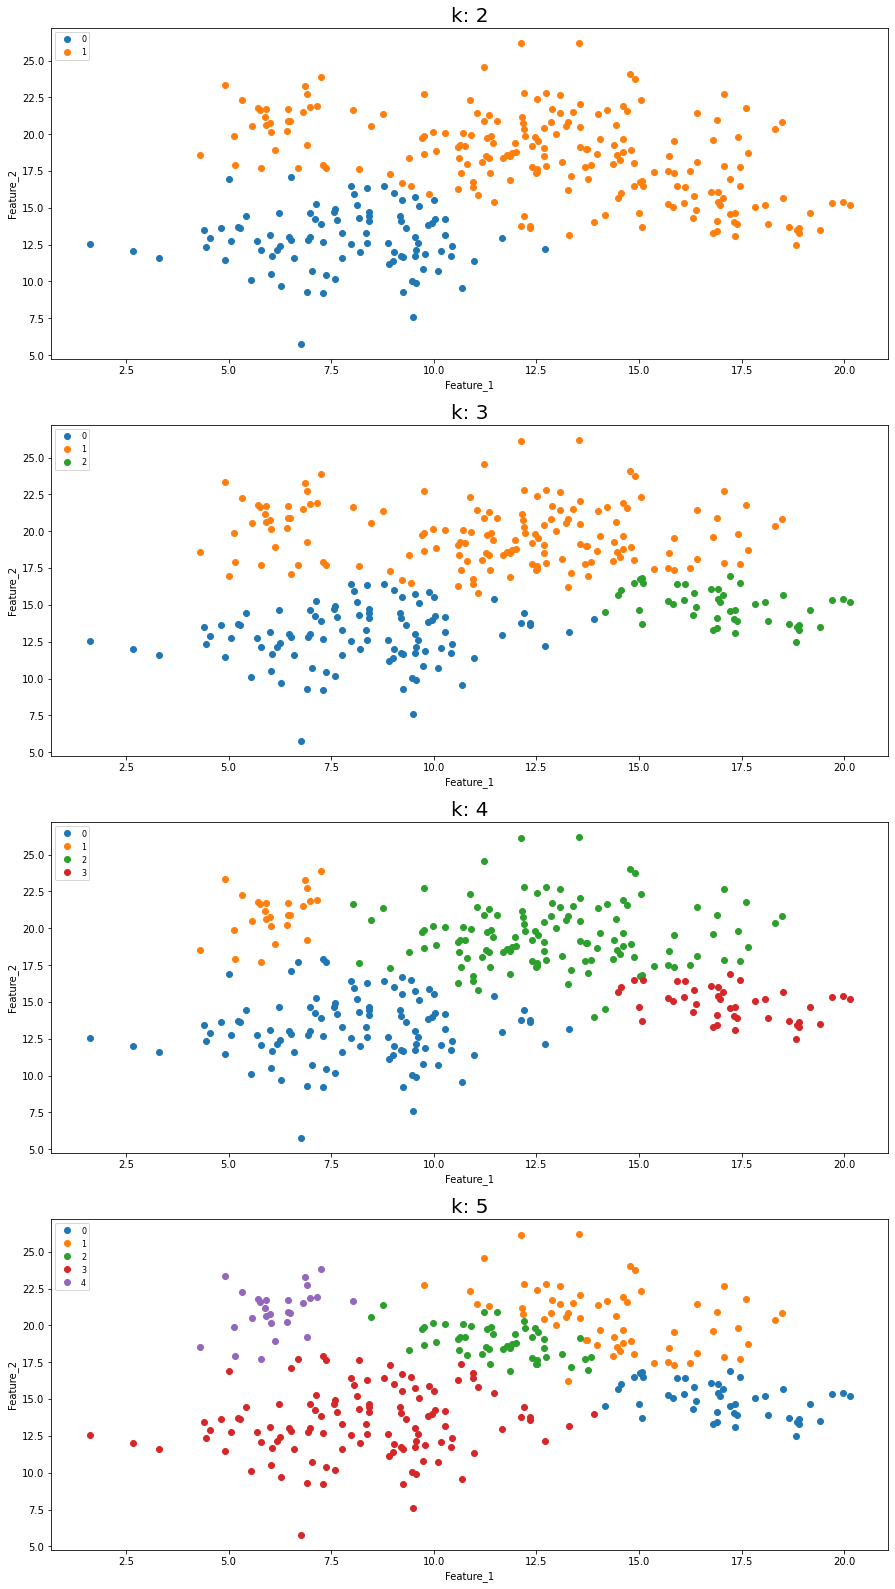

In [9]:
probe.calculate(raw_data)
probe.show_plot()

## Conclude
- It is judged that the clustering is best when k from 4 to 5